In [1]:
import os # for detecting CPU cores
import configparser # to load standard config and parameters
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%load_ext watermark
%matplotlib inline


In [2]:
# Load external config file
config = configparser.ConfigParser()
config.read("../src/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "0x_deep_learning_test" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 8


In [3]:
train_df = pd.read_pickle(PATH_DATA_INT+'train-opt.pkl')
test_df = pd.read_pickle(PATH_DATA_INT+'test-opt.pkl')
sample_df = pd.read_csv(PATH_DATA_RAW+'sample_submission.csv')

In [4]:
features_num = train_df.drop(['id','target'], axis=1).columns
X = train_df.drop(['id','target'], axis=1).copy()
y = train_df['target'].copy()

X_test = test_df.drop(['id'], axis=1).copy()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

transformer_num = make_pipeline(
    StandardScaler(),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]
print(input_shape)

[100]


In [6]:
import gc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
import gc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

gc.collect()

model = keras.Sequential(
    [
        #layers.BatchNormalization(input_shape=input_shape),
        layers.Dense(2, activation="relu", input_shape=input_shape),
        layers.Dense(4, activation="relu"),
        layers.Dense(2, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

model.compile(
    optimizer="sgd",
    #optimizer='adam',
    loss="binary_crossentropy",
    # metrics=['binary_accuracy'],
    metrics=["AUC"],
)

early_stopping = EarlyStopping(
    patience=40, min_delta=0.001, restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    #batch_size=1024,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,  # hide the output because we have so many epochs
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4)                 404       
                                                                 
 dense_5 (Dense)             (None, 4)                 20        
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 429
Trainable params: 429
Non-trainable params: 0
_________________________________________________________________


Best Validation Loss: 0.564996
Best Validation AUC: 0.749912


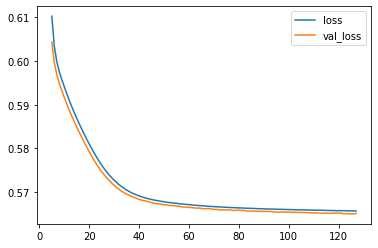

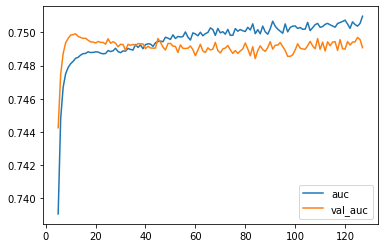

In [9]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ["loss", "val_loss"]].plot()
history_df.loc[5:, ["auc", "val_auc"]].plot()

print(
    ("Best Validation Loss: {:0.6f}" + "\nBest Validation AUC: {:0.6f}").format(
        history_df["val_loss"].min(), history_df["val_auc"].max()
    )
)

# ADAM:
# Best Validation Loss: 0.564178
# Best Validation Accuracy: 0.757301

# SGD:
# Best Validation Loss: 0.565582
# Best Validation Accuracy: 0.750882


In [10]:
preds_test = model.predict(X_test)

In [11]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
now = now.strftime("%Y-%m-%d")

#mlflow_run_id = str(run.info.run_id)
objective = "dl_test"

curr_submission_fn = f"{now}_submission_{objective}.csv"

sample_df['target'] = preds_test
sample_df.to_csv(PATH_SUB + curr_submission_fn, index=False)

print(curr_submission_fn)

2021-11-09_submission_dl_test.csv


In [12]:
sample_df.tail()

,id,target
539995,1139995,0.754631
539996,1139996,0.752903
539997,1139997,0.747696
539998,1139998,0.753363
539999,1139999,0.750395


In [13]:
#!kaggle competitions submit tabular-playground-series-nov-2021 -f {PATH_SUB+curr_submission_fn} -m {curr_submission_fn}##

## Hyperparameter Tuning w/ Optuna

In [14]:
import warnings
from icecream import ic
import optuna

from keras.backend import clear_session
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import adam_v2
#from keras.optimizers import RMSprop

In [15]:
gc.collect()

8676

In [16]:
N_TRAIN_EXAMPLES = 3000
N_VALID_EXAMPLES = 1000
BATCHSIZE = 128
CLASSES = 10
EPOCHS = 10

In [17]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()

    train_df = pd.read_pickle(PATH_DATA_INT + "train-opt.pkl")
    X = train_df.drop(["id", "target"], axis=1)
    y = train_df["target"]

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, stratify=y, train_size=0.75
    )

    input_shape = [X_train.shape[1]]
    # ic(input_shape)

    model = Sequential()

    n_layers = trial.suggest_int("n_layers", 1, 4)
    learning_rate = trial.suggest_float("min_delta", 0.001, 0.1, log=True)
    patience = trial.suggest_int("patience", 20, 100, log=True)
    #min_delta = trial.suggest_float("min_delta", 0.001, 0.1, log=True)

    # model.add(keras.layers.Flatten())
    # model.add(layers.Dense(input_shape=input_shape, activation="relu"))

    for i in range(n_layers):
        num_hidden = trial.suggest_int(f"n_units_l{i}", 4, 128, log=True)
        ic(num_hidden)
        model.add(layers.Dense(num_hidden, activation="relu", input_shape=input_shape))

    # last layer
    model.add(Dense(1, activation="sigmoid"))

    # optimizer=trial.suggest_categorical("activation", ["sgd", "adam"]),

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        metrics=["AUC"],
    )

    # ic(patience)

    early_stopping = EarlyStopping(
        patience=patience, min_delta=learning_rate, restore_best_weights=True,
    )

    model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        # shuffle=True,
        batch_size=512,
        # batch_size=1024,
        epochs=1000,
        callbacks=[early_stopping],
        verbose=0,  # hide the output because we have so many epochs
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score[1]


In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-11-09 20:11:06,976] A new study created in memory with name: no-name-4be0770b-9ff0-4b0f-8838-c9bf03911311
ic| num_hidden: 88
ic| num_hidden: 15
ic| num_hidden: 34
[I 2021-11-09 20:20:51,895] Trial 0 finished with value: 0.7276347279548645 and parameters: {'n_layers': 3, 'min_delta': 0.0029252304172142462, 'patience': 49, 'n_units_l0': 88, 'n_units_l1': 15, 'n_units_l2': 34}. Best is trial 0 with value: 0.7276347279548645.
ic| num_hidden: 17
ic| num_hidden: 21
ic| num_hidden: 6
